<a href="https://colab.research.google.com/github/PeterSpitz/cap-comp215/blob/main/comp_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# clears print output to remove clutter
from IPython.display import clear_output
#imports for graphs
import matplotlib
import matplotlib.pyplot as plt
import datetime, json, requests, math
from pprint import pprint    # Pretty Print - built-in python function to nicely format data structures

In [2]:
START_DATE = "2026-01-15" #yyyy-mm-dd returns one week of data
ASTEROID_ID = 54577248 #int. set to None to skip search
ASTEROID_NAME = None #str. set to None to skip search
#if name and id are both set, but point to different asteroids the search will fail
DANGEROUS = False #bool. any value other than True skips search
ORBITING_BODY = None #str. set to None to skip search

In [3]:
API_KEY = 'S896m0XG5ds8v5gN97Gsa8Fh8YrnXrIpPEoqnkPF'  # substitute your API key here

def get_neos(start_date):
    """ Return a list of NEO for the week starting at start_date """
    url = f'https://api.nasa.gov/neo/rest/v1/feed?start_date={start_date}&api_key={API_KEY}'
    # Fetch last week's NEO feed
    response = requests.request("GET", url, headers={}, data={})
    data = json.loads(response.text)
    return [neo for dated_records in data['near_earth_objects'].values() for neo in dated_records ]

def get_neo(id):
    """ Return a NEO record for the given id """
    url = f'https://api.nasa.gov/neo/rest/v1/neo/{id}?api_key={API_KEY}'
    response = requests.request("GET", url, headers={}, data={})
    return json.loads(response.text)

neos = get_neos(START_DATE)
print(f'{len(neos)} Near Earth Objects found for week of {START_DATE}')
assert len(neos) > 0, f'Oh oh!  No NEOs found for {START_DATE}'
neo = get_neo(neos[-1]['id'])  # get the very latest NEO
#pprint(neo)
pprint(len(neo['close_approach_data']))
pprint(neos[-1])

130 Near Earth Objects found for week of 2026-01-15
3
{'absolute_magnitude_h': 28.703,
 'close_approach_data': [{'close_approach_date': '2026-01-21',
                          'close_approach_date_full': '2026-Jan-21 09:16',
                          'epoch_date_close_approach': 1768986960000,
                          'miss_distance': {'astronomical': '0.0025659842',
                                            'kilometers': '383865.770773654',
                                            'lunar': '0.9981678538',
                                            'miles': '238523.1294942652'},
                          'orbiting_body': 'Earth',
                          'relative_velocity': {'kilometers_per_hour': '45591.616540823',
                                                'kilometers_per_second': '12.664337928',
                                                'miles_per_hour': '28328.8575111575'}}],
 'estimated_diameter': {'feet': {'estimated_diameter_max': 35.4343956449,
             

In [4]:
class CloseApproach:
  '''stores desired data from a single object'''

  def __init__(self, orbiting_body:str, approach_date:datetime, miss_distance:float, velocity:float):
    self.orbiting_body = orbiting_body
    self.approach_date = approach_date
    self.miss_distance = miss_distance
    self.velocity = velocity

  def __str__(self):
    return f"Object will approach {self.orbiting_body} on {self.approach_date} traveling {self.velocity}km/hr at a distance of {self.miss_distance}km"


In [5]:
def get_close_approach(record):
  '''processes data from single neo record into a closeapproach object'''

  return CloseApproach(
    record['orbiting_body'],
    datetime.datetime.strptime(record['close_approach_date_full'], "%Y-%b-%d %H:%M"), #converts string into datetime object
    float(record['miss_distance']['kilometers']),
    float(record['relative_velocity']['kilometers_per_hour'])
  )


In [6]:
class Asteroid:
  '''stores data for a single asteroid'''

  def __init__(self, id:int, name:str, d_min:float, d_max:float, hazard:bool, close:list = []) -> None:
    self.id = id
    self.name = name
    self.d_min = d_min
    self.d_max = d_max
    self.hazard = hazard
    self.close = close #list of nearby objects

  def __str__(self) -> str:
    return f"Asteroid:{self.name}\nid:{self.id}\ndiameter:{self.d_min}-{self.d_max}\nhazardous:{self.hazard}\nnumber of close approaches: {len(self.close)}"

  def nearest_miss(self) -> CloseApproach:
    '''find the closest miss'''
    test = sorted(self.close, key=lambda CloseApproach: CloseApproach.miss_distance)
    return test[0]


In [7]:
def asteroids_from_neo(neo_id:int, neo_name:str, orbit:str, danger:bool):
  '''creates a list of asteroid objects from search parameters'''

  #list of neos. Always assume more than one result from search
  temp_neo = get_neos(START_DATE)

  #filter by id
  if neo_id != None:
    for i in range(len(temp_neo)):
      if int(temp_neo[i]["id"]) == neo_id:
        temp_neo = [temp_neo[i]]
        break

  #filter by name
  if neo_name != None:
    for i in range(len(temp_neo)):
      if temp_neo[i]["name"] == neo_name:
        temp_neo = [temp_neo[i]]
        break

  #filter by dangerous
  if danger == True:
    temp_neo = [x for x in temp_neo if x["is_potentially_hazardous_asteroid"] == True]

  #filter by orbiting body
  close = [0 for i in range(len(temp_neo))] #list of close approach lists

  if len(temp_neo) > 0: #check if any valid asteroids are left
    for i in range(len(temp_neo)):
      temp_neo[i] = get_neo(neos[i]['id'])  #update list with full close approach list

    if orbit == None:
      for i in range(len(temp_neo)): #check each asteroid
        close[i] = ([get_close_approach(x) for x in temp_neo[i]['close_approach_data']])
    else:
      for i in range(len(temp_neo)):
        #can fail to find any match resulting in an empty list. add check before graph call
        close[i] = ([get_close_approach(x) for x in temp_neo[i]['close_approach_data'] if x['orbiting_body'] == orbit])

  result = []

  if len(temp_neo) > 0:
    for i in range(len(temp_neo)):
      result.append(Asteroid(temp_neo[i]["id"],
                            temp_neo[i]['name'],
                            float(temp_neo[i]['estimated_diameter']['kilometers']['estimated_diameter_min']),
                            float(temp_neo[i]['estimated_diameter']['kilometers']['estimated_diameter_max']),
                            temp_neo[i]['is_potentially_hazardous_asteroid'],
                            close[i]
                            ))

    return result
  else:
    #search failed
    return None


In [16]:

def draw_graph(asteroid):
  '''takes in an asteroid and plots close approach distance vs dates'''
  x = []
  y = []

  for a in range(len(asteroid)):
    for i in range(len(asteroid[a].close)):
      x.append(asteroid[a].close[i].approach_date)
      y.append(asteroid[a].close[i].miss_distance)

    #add new line with label
    plt.plot(x, y, label = asteroid[a].name)

  #display comlete graph
  plt.show()


searched 130 asteroids
found 1 matches


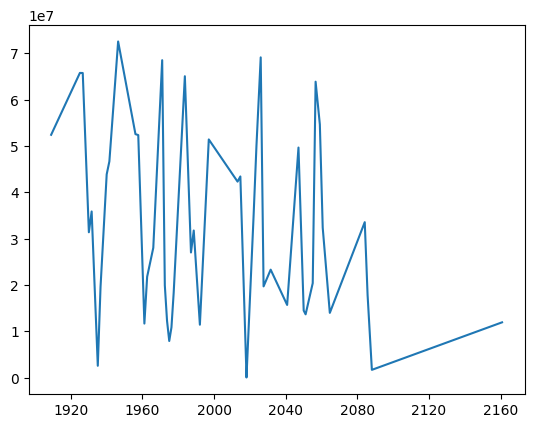

In [17]:
def main():
  asteroid_list = asteroids_from_neo(ASTEROID_ID, ASTEROID_NAME, ORBITING_BODY, DANGEROUS)

  if asteroid_list == None:
    print(f"searched {len(neos)} asteroids\nfound 0 matches")
  else:
    print(f"searched {len(neos)} asteroids\nfound {len(asteroid_list)} matches")

    draw_graph(asteroid_list)

main()